In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/GMGD.jl")

visualization_2d (generic function with 1 method)

# 1-Parameter Square Map
The posterior distribution is studied  numerically on the following nonlinear 1-parameter problem:

$$
\begin{equation*}
y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
\end{equation*}
$$    


We assume the observation is $y = 1$ and the piror is $\mathcal{N}(3, 2^2)$, we consider the following cases

$$
\begin{align*}
&A: \eta \sim \mathcal{N}(0, 1^2)\\
&B: \eta \sim \mathcal{N}(0, 0.5^2)\\
&C: \eta \sim \mathcal{N}(0, 0.2^2)\\
\end{align*}
$$ 

In [2]:
function G(θ)
    #return θ
    return [θ'*θ; θ]
end


function F(θ, args)
    y, ση = args
    Gθ = G(θ)
    return (y - Gθ) ./ ση
end


function logrho(θ, args)
    Fθ = F(θ, args)
    return -0.5*norm(Fθ)^2
end


function V(θ, args)
    return -logrho(θ, args), 
           -ForwardDiff.gradient(x -> logrho(x, args), θ), 
           -ForwardDiff.hessian(x -> logrho(x, args), θ)
end


V (generic function with 1 method)

In [3]:
function Gaussian_mixture_VI(func_V, func_F, w0, μ0, Σ0; N_iter = 100, dt = 1.0e-3)

    N_modes, N_θ = size(μ0)
    

    
    T =  N_iter * dt
    N_modes = 1
    x0_w = w0
    x0_mean = μ0
    xx0_cov = Σ0
    sqrt_matrix_type = "Cholesky"
    
    objs = []

    if func_V !== nothing
#         gmgdobj = GMGD_Run(
#         func_V, 
#         T,
#         N_iter,
#         # Initial condition
#         x0_w, x0_mean, xx0_cov;
#         sqrt_matrix_type = sqrt_matrix_type,
#         # setup for Gaussian mixture part
#         quadrature_type_GM = quadrature_type_GM,
#         # setup for potential function part
#         Bayesian_inverse_problem = false, 
#         quadrature_type = "cubature_transform_o3")
        
        
        gmgdobj = GMGD_Run(
        func_V, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        sqrt_matrix_type = sqrt_matrix_type,
        # setup for Gaussian mixture part
        quadrature_type_GM = "mean_point",
        # setup for potential function part
        Bayesian_inverse_problem = false, 
        quadrature_type = "mean_point")
        
        push!(objs, gmgdobj)

    end

    if func_F !== nothing
        N_f = length(func_F(ones(N_θ)))
        gmgdobj_BIP = GMGD_Run(
        func_F, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        sqrt_matrix_type = sqrt_matrix_type,
        # setup for Gaussian mixture part
        quadrature_type_GM = "mean_point",
        # setup for potential function part
        Bayesian_inverse_problem = true, 
        N_f = N_f,
        quadrature_type = "unscented_transform",
        c_weight_BIP = 1.0e-4,
        w_min=1e-10)
        
        push!(objs, gmgdobj_BIP)

    end

    return objs
end




Gaussian_mixture_VI (generic function with 1 method)

[ Info: [-2.4283140297584804; 1.7456283123426095; -0.894645096090581; 0.2906437638479689; -1.6739506493393108; -1.1302825060071122; 0.6935712151863443; 1.2689110758399453; 1.0765700107367757; -0.5294629063965713; 1.2286255729401245; 1.888404666526958; -1.1820278698524544; -1.1565112786553444; -1.0892903110609817; -1.7378812608703986; -0.8814644466483343; 3.031202438624696; 2.3527643464748262; -0.20843204345603042;;]
[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 100)
[ Info: ("iter = ", 60, " / ", 100)
[ Info: ("iter = ", 70, " / ", 100)
[ Info: ("iter = ", 80, " / ", 100)
[ Info: ("iter = ", 90, " / ", 100)
[ Info: ("iter = ", 100, " / ", 100)
[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 100)
[ Info: ("iter = ", 60, " / ", 100)
[ I

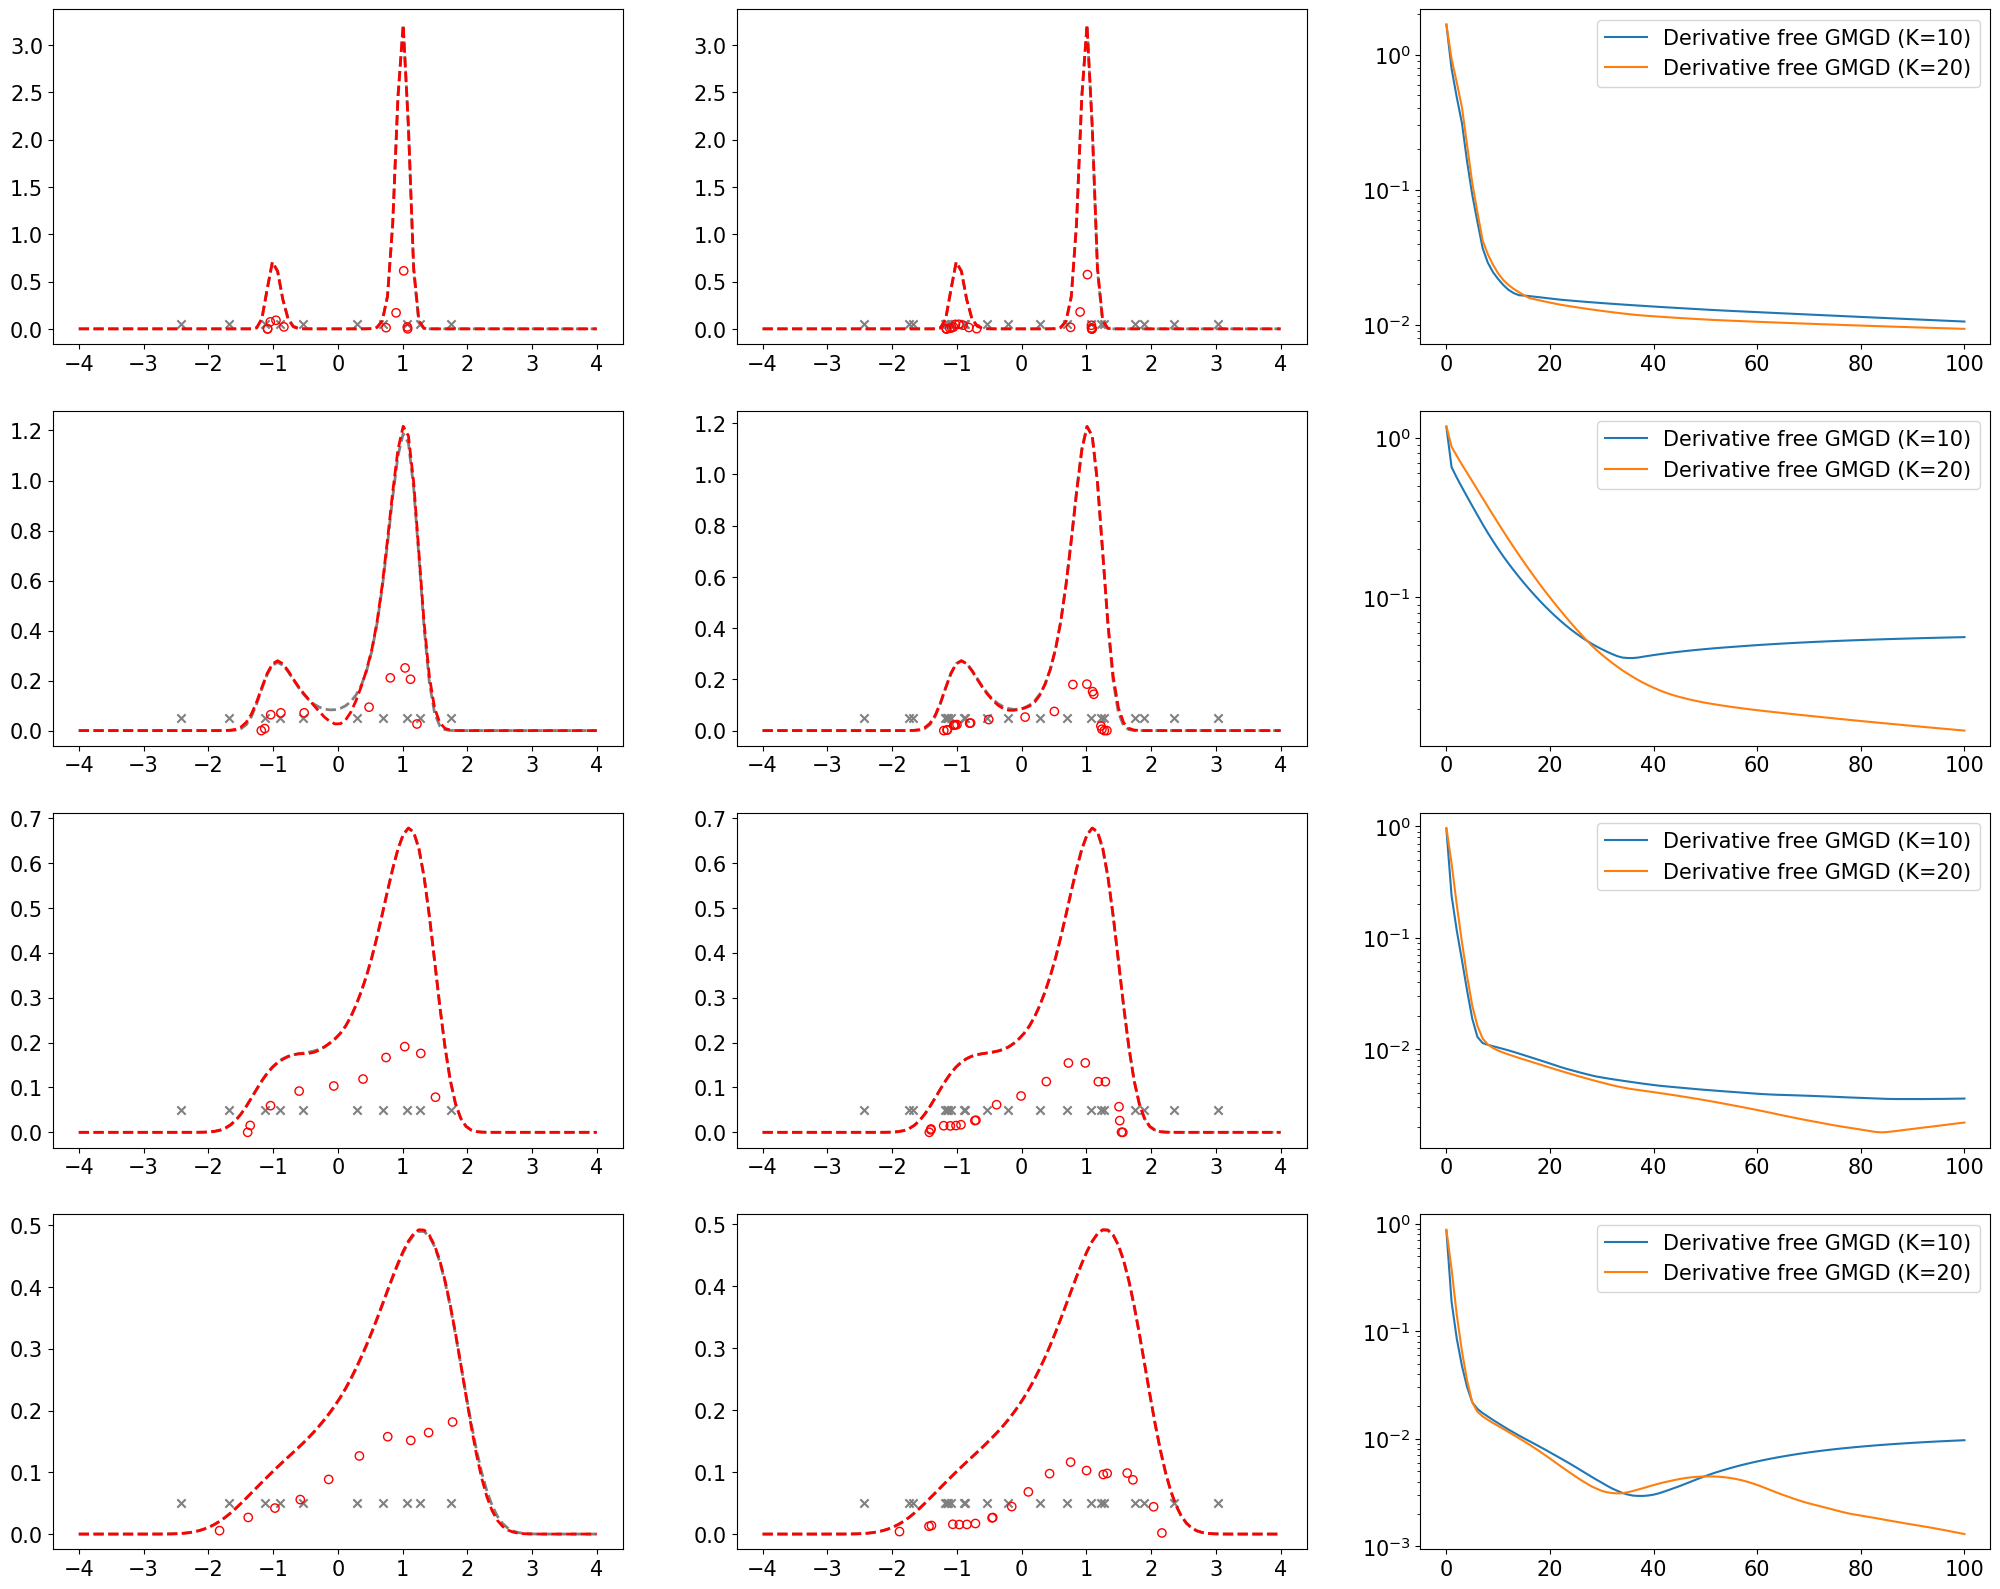

PyObject <matplotlib.legend.Legend object at 0x34be71e40>

In [10]:
include("../Inversion/GMGD.jl")
fig, ax = PyPlot.subplots(nrows=4, ncols=3, sharex=false, sharey=false, figsize=(25,20))

    
Random.seed!(111);
N_modes = 20
x0_w  = ones(N_modes)/N_modes
μ0, σ0 = 3.0, 2.0
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(Normal(0, σ0))
    xx0_cov[im, :, :] .= σ0^2
end
@info x0_mean

N_iter = 100
Nx = 100
y = [1.0; 3.0]

ση = [0.2; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
dt = 5e-1
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = dt)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1])
visualization_1d(ax[1,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)


ση = [0.5; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
dt = 1e-1
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = dt)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1])
visualization_1d(ax[2,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)


ση = [1.0; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
dt = 5e-1
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = dt)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1])
visualization_1d(ax[3,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)



ση = [2.0; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
dt = 5e-1
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = dt)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1])
visualization_1d(ax[4,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)

# fig.tight_layout()
# fig.savefig("DFGMGD.pdf")

[ Info: [-2.4283140297584804; 1.7456283123426095; -0.894645096090581; 0.2906437638479689; -1.6739506493393108; -1.1302825060071122; 0.6935712151863443; 1.2689110758399453; 1.0765700107367757; -0.5294629063965713; 1.2286255729401245; 1.888404666526958; -1.1820278698524544; -1.1565112786553444; -1.0892903110609817; -1.7378812608703986; -0.8814644466483343; 3.031202438624696; 2.3527643464748262; -0.20843204345603042; 0.37625002883165437; 4.625266266358157; -0.7768116801787522; -2.577627153664709; 0.06163600909856056; 0.06112355864123673; 2.3053323165504085; 0.23492177715726334; -3.4444767955447713; -0.1416794678161199; 3.195802461216582; 2.3334894673888216; 1.4173378412112398; -0.3258329008328327; -4.023108250670748; 0.7455107628315424; -1.359552597503293; 0.661789724887017; 1.7705184917242267; 2.0012318851206143;;]
[ Info: ("iter = ", 10, " / ", 100)
[ Info: ("iter = ", 20, " / ", 100)
[ Info: ("iter = ", 30, " / ", 100)
[ Info: ("iter = ", 40, " / ", 100)
[ Info: ("iter = ", 50, " / ", 

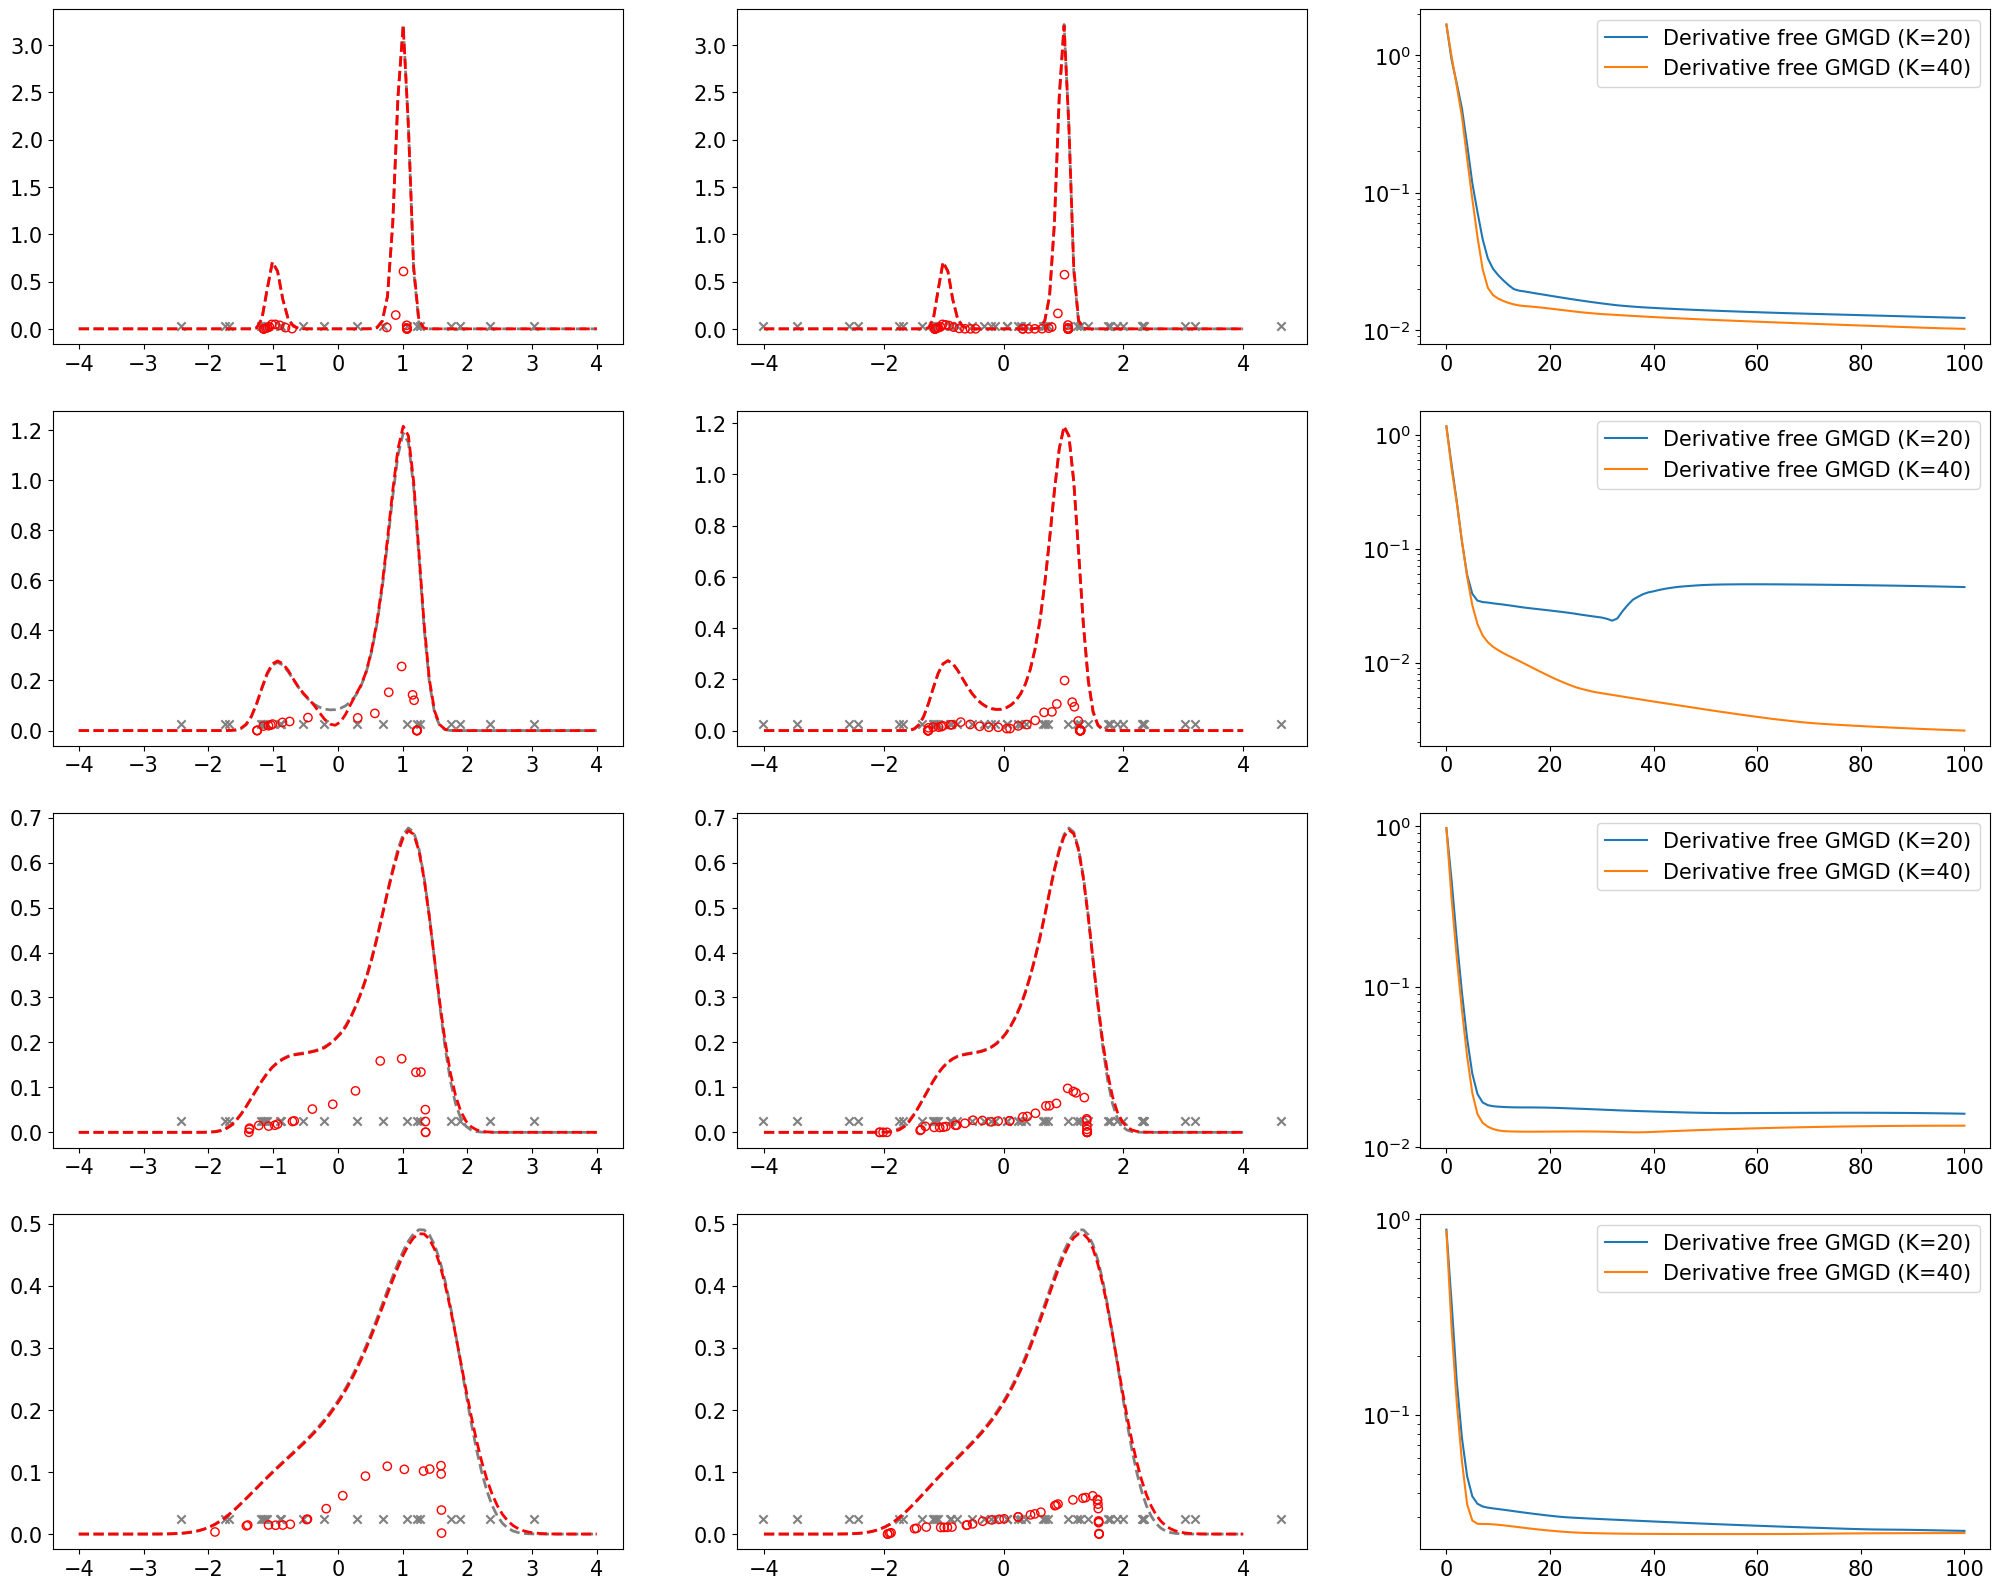

PyObject <matplotlib.legend.Legend object at 0x350ca67d0>

In [12]:
include("../Inversion/GMGD.jl")
fig, ax = PyPlot.subplots(nrows=4, ncols=3, sharex=false, sharey=false, figsize=(25,20))

    
Random.seed!(111);
N_modes = 40
x0_w  = ones(N_modes)/N_modes
μ0, σ0 = 3.0, 2.0
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(Normal(0, σ0))
    xx0_cov[im, :, :] .= σ0^2
end
@info x0_mean

N_iter = 100
Nx = 100
y = [1.0; 3.0]

ση = [0.2; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
dt = 5e-1
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = dt)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1])
visualization_1d(ax[1,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)


ση = [0.5; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
dt = 5e-1
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = dt)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1])
visualization_1d(ax[2,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)


ση = [1.0; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
dt = 5e-1
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = dt)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1])
visualization_1d(ax[3,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)



ση = [2.0; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
dt = 5e-1
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = dt)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt)[1])
visualization_1d(ax[4,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)

# fig.tight_layout()
# fig.savefig("DFGMGD.pdf")

# With Derivatives

[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("

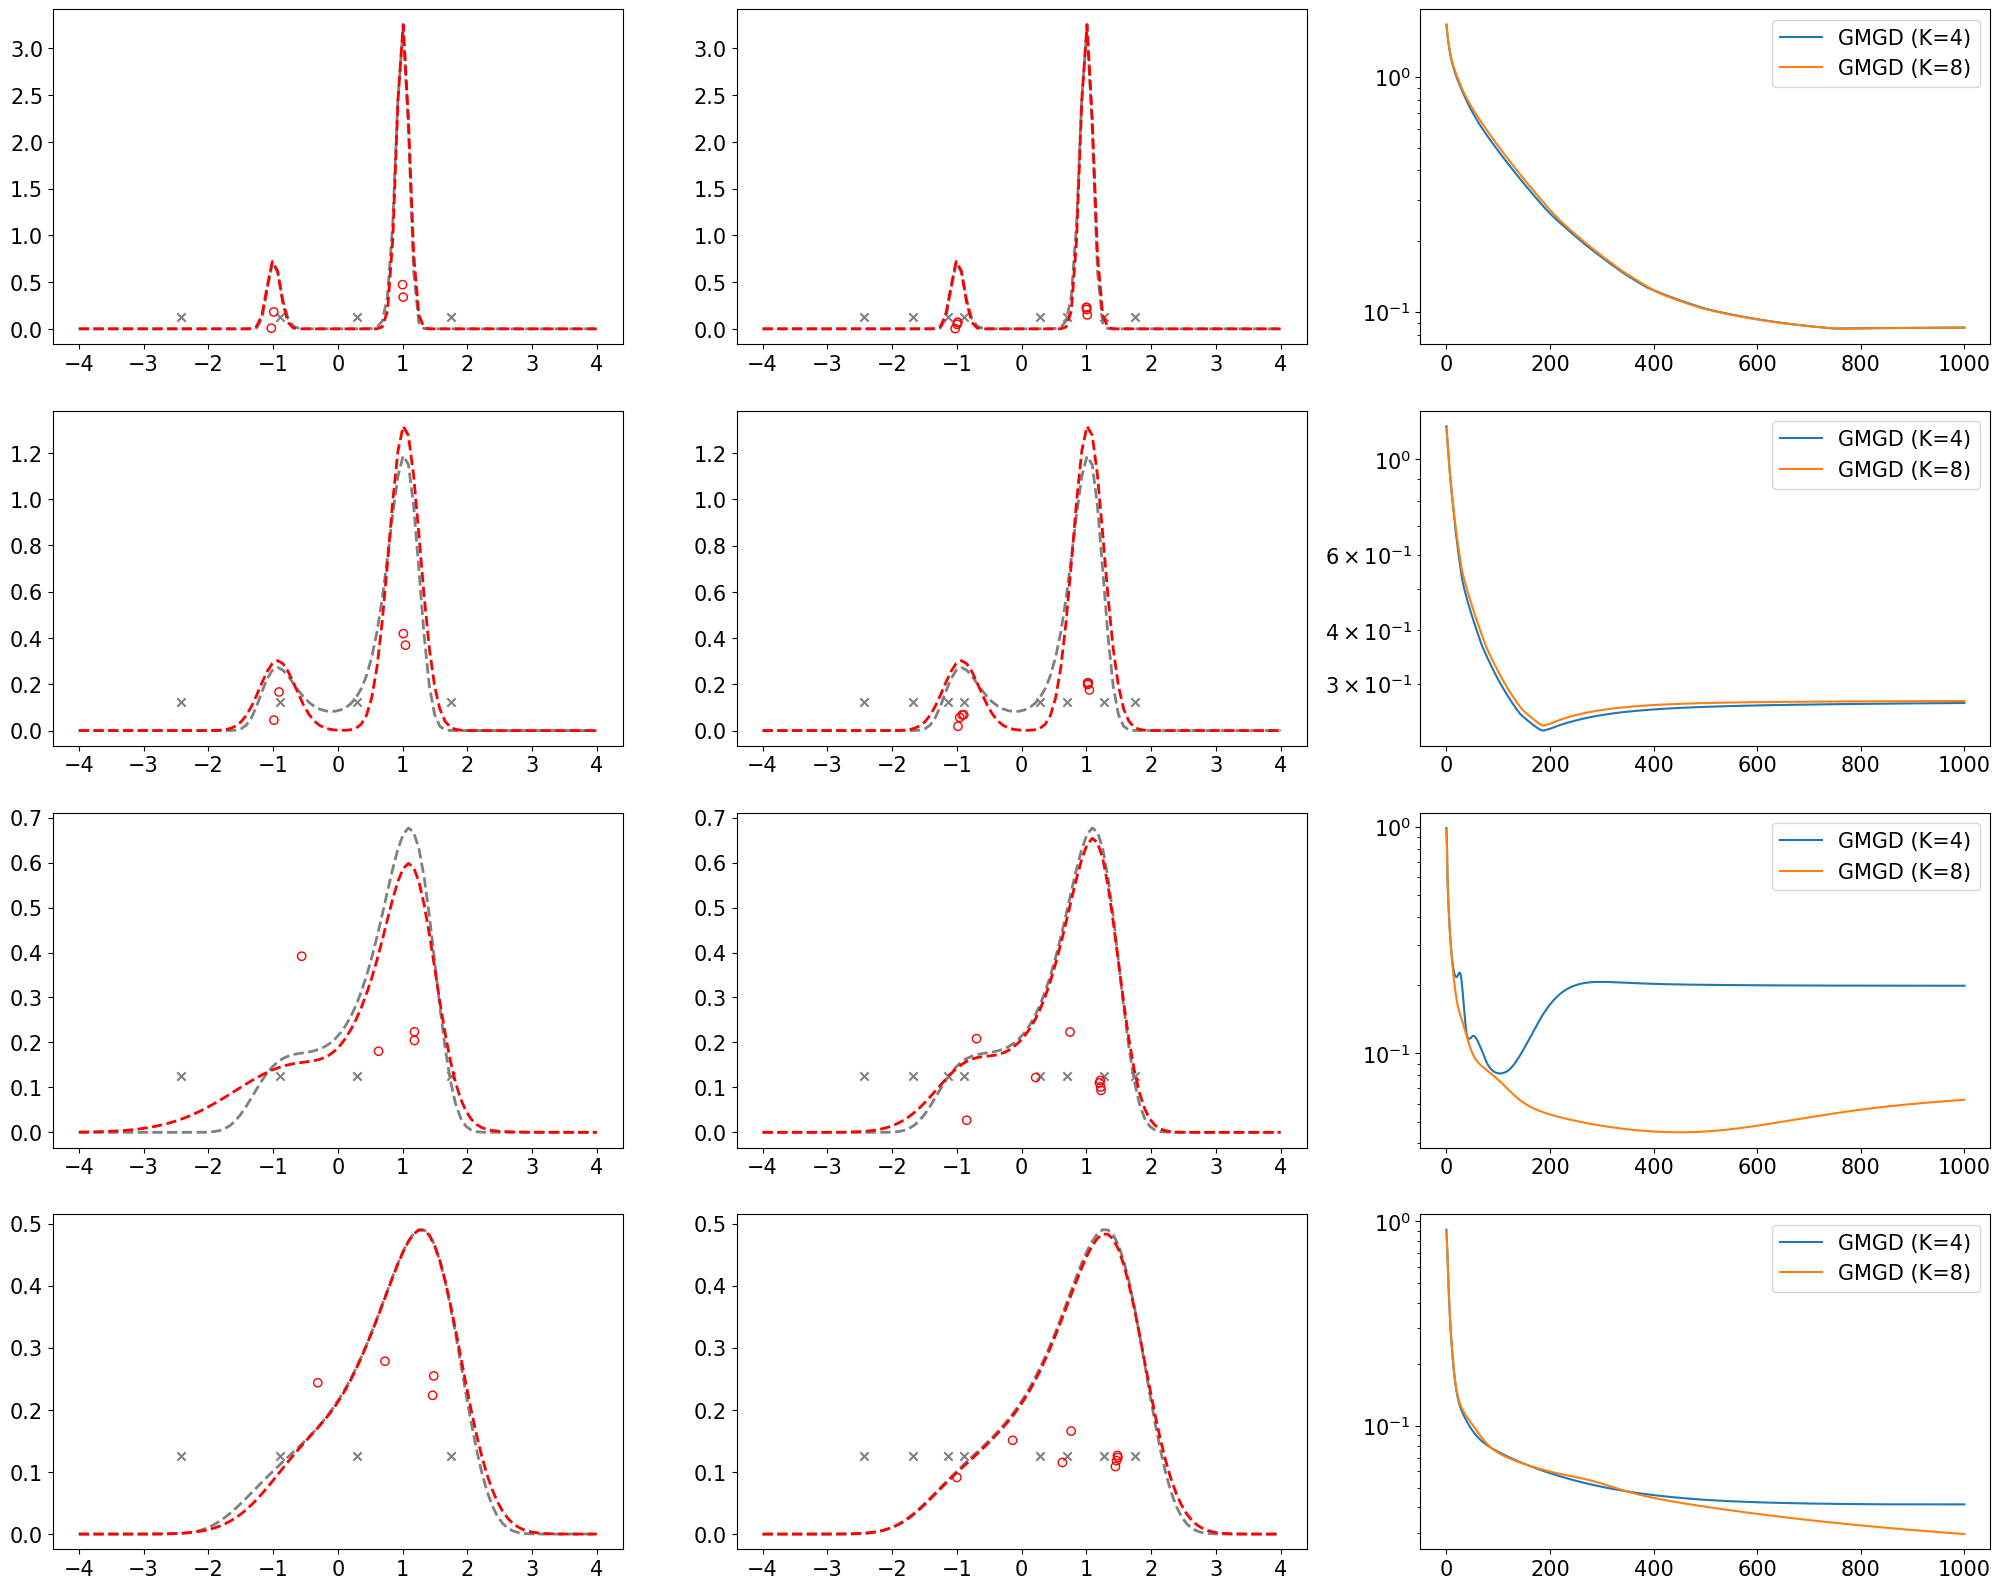

PyObject <matplotlib.legend.Legend object at 0x3c5501e70>

In [111]:
include("../Inversion/GMGD.jl")
fig, ax = PyPlot.subplots(nrows=4, ncols=3, sharex=false, sharey=false, figsize=(25,20))

    
Random.seed!(111);
N_modes = 8
x0_w  = ones(N_modes)/N_modes
μ0, σ0 = 3.0, 2.0
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(Normal(0, σ0))
    xx0_cov[im, :, :] .= σ0^2
end


N_iter = 1000
Nx = 100
y = [1.0; 3.0]

ση = [0.2; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(func_dV, nothing, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 5e-3)[1],
        Gaussian_mixture_VI(func_dV, nothing, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 5e-3)[1])
visualization_1d(ax[1,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)


ση = [0.5; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(func_dV, nothing, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-2)[1],
        Gaussian_mixture_VI(func_dV, nothing, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-2)[1])
visualization_1d(ax[2,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)


ση = [1.0; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(func_dV, nothing, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(func_dV, nothing, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_1d(ax[3,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)



ση = [2.0; 2.0]
func_args = (y, ση)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(func_dV, nothing, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(func_dV, nothing, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_1d(ax[4,:]; Nx = Nx, x_lim=[-4.0, 4.0], func_F=func_F, objs=objs)

# fig.tight_layout()
# fig.savefig("DFGMGD.pdf")